# Other Clustering Methods

In this exercise, we'll go through clustering algorithms beyond *k* -means. Namely, **mean-shift**, **spectral clustering**, and **affinity propagation**.  We'll introduce and explain each one in turn and follow it up with an example.

Each example will use the same simulated dataset containing 3 blobs of points.

In [5]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set_style('darkgrid')

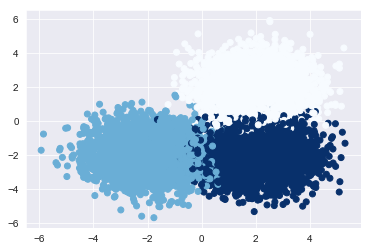

In [7]:
# The coordinates of the centers of our blobs.
centers = [[2, 2], [-2, -2], [2, -2]]

# Make 10,000 rows worth of data with two features representing three
# clusters, each having a standard deviation of 1.
X, y = make_blobs(
    n_samples=10000,
    centers=centers,
    cluster_std=1,
    n_features=2,
    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Blues')
plt.show()

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

# Mean-shift

The mean-shift algorithm first calculates a probability density surface (technically, a *kernel density surface*) across the entire population space.  Then, the algorithm iteratively moves each point in the uphill direction.  If the point is at the top of a probability hill already, it stays put.  Once the shifts are smaller than a predetermined threshold, the algorithm terminates and the points are assigned to a cluster based on the hill they end on.  

Mean shift makes no assumption about the nature of the data nor the number of clusters.  In fact, some points may not end up clustered at all. This would happen if the points start out in a very flat portion of the probability surface.

One critical user parameter, *bandwidth*, defines the smoothness of the starting probability surface.  A high bandwith (up to 1) will create a smoother surface and a low bandwith (down to 0).

While mean-shift is a good clustering algorithm if you don't know how many clusters to expect, or if you know your clusters are heterogeneous in size and/or shape, it is a computationally expensive algorithm.  Thus, it is best left for small to medium-sized datasets only.

In [11]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Setting the bandwidth using an automatic function which inspects 
# the distances among points in the data
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)
y_pred = ms.fit_predict(X_test)

# Extract cluster assignments for each data point
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count of clusters
n_clusters_ = len(np.unique(labels))

print(f'Number of estimated clusters: {n_clusters_}')

Number of estimated clusters: 3


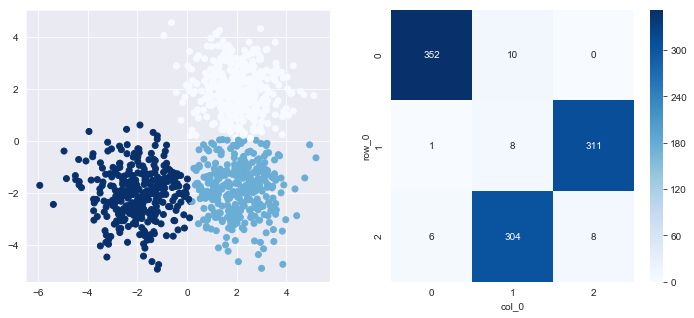

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, cmap='Blues')

plt.subplot(122)
sns.heatmap(pd.crosstab(y_train, labels), vmin=0, annot=True, fmt='g', cmap='Blues')
plt.show()

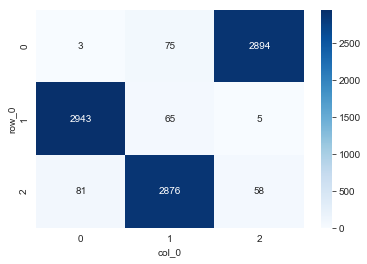

In [14]:
sns.heatmap(pd.crosstab(y_test, y_pred), vmin=0, annot=True, fmt='g', cmap='Blues')
plt.show()


While the confusion matrices don't look right (something with the class labels is messed up) the clustering algorithm is obviously performing well.

# Spectral clustering

Spectral clustering is based on quantifying the similarity between data points.  Any measure of similarity can be selected by the user, but common measures are *nearest neighbor* and the *radial basis function* (or Gaussian kernal of the Euclidean distance).  The only necessity is that the function computes pairwise similarity with 0 meaning no similarity and higher numbers indicating greater similarity.  

This clustering alogrithm defines a similarity matrix of *n x n* dimensions, where n is the number of samples in the data set, and each value represents the indices of similarity for every pairwise combination of points.  Then, a transformation matrix is applied to calculate a set of eigenvectors with appropriate eigenvalues. In other words, this is PCA but done on a similarity matrix instead of a covariance matrix.

The number of clusters, *k* , is user defined.  The PCA-like step will output the *k* eigenvectors with the *k* largest eigenvalues, extracted and converted to the new *k* -dimensional space.  Following the dimensionality reduction, the *k* -means algorithm is applied to extract the *k* clusters.

Similar to *k* -means, spectral clustering is slow and works best when the clusters are equal in size.  However, unlike *k* -means, it can identify clusters with non-flat geometry and clusters that are not necessarily globlar in the original dimensional space.

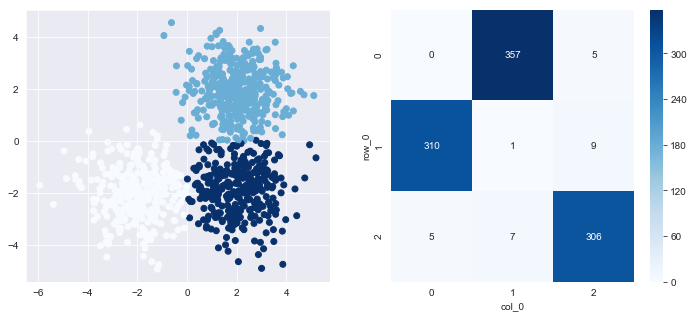

In [17]:
from sklearn.cluster import SpectralClustering

n_clusters = 3

sc = SpectralClustering(n_clusters=n_clusters)
Y_sc_pred = sc.fit_predict(X_train)


plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_sc_pred, cmap='Blues')

plt.subplot(122)
sns.heatmap(pd.crosstab(y_train, Y_sc_pred), vmin=0, annot=True, fmt='g', cmap='Blues')
plt.show()


This is a very similar outcome to mean-shift clustering.

# Affinity propagation

It's complex, computationally expensive, and memory intensive.  The [SKlearn documenation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation) is much clearer than the Thinkful documentation.

In [18]:
from sklearn.cluster import AffinityPropagation

# Providing no arguments to see what the defaults produce
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the model information
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print(f'Estimated number of clusters: {n_clusters_}')

Done
Estimated number of clusters: 93


Well since we didn't supply any arguments, the Affinity Propagation clustering algorithm went wild.  Let's see what it actually produced before we attempt to reign it in.

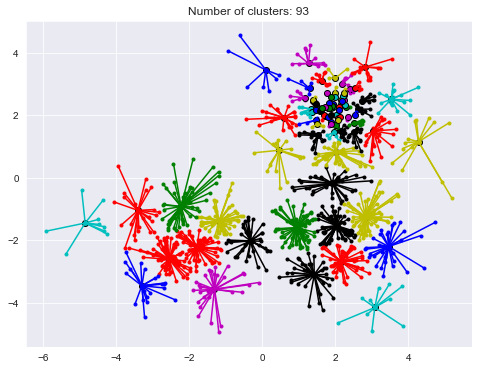

In [20]:
from itertools import cycle

plt.figure(1, figsize=(8,6))
plt.clf()

# Cycle through each cluster, graph the exemplar as a point and lines
# connecting each point to it's exemplar
colors = cycle('bgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0], 
             cluster_center[1], 
             'o', 
             markerfacecolor=col, 
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
        
plt.title(f'Number of clusters: {n_clusters_}')
plt.show()

Yup, this algorithm went crazy.  Let's try to make it behave within reason.

In [40]:
# Changing the Affinity Propagation arguments
# Very high damping effect
af = AffinityPropagation(damping=.98505).fit(X_train)

# Pull the model information
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print(f'Estimated number of clusters: {n_clusters_}')

Estimated number of clusters: 3


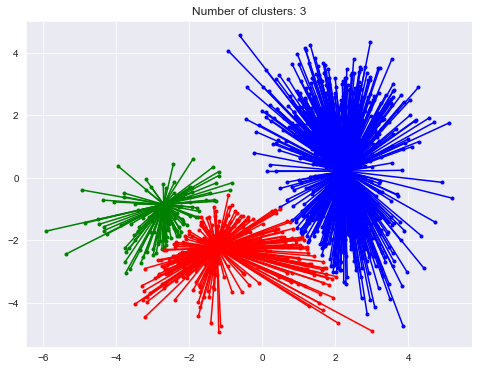

In [41]:
from itertools import cycle

plt.figure(1, figsize=(8,6))
plt.clf()

# Cycle through each cluster, graph the exemplar as a point and lines
# connecting each point to it's exemplar
colors = cycle('bgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0], 
             cluster_center[1], 
             'o', 
             markerfacecolor=col, 
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
        
plt.title(f'Number of clusters: {n_clusters_}')
plt.show()

In [50]:
# Changing the Affinity Propagation arguments
# Default damping, invoking preference
af = AffinityPropagation(damping=.985, max_iter=10000, verbose=True).fit(X_train)

# Pull the model information
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print(f'Estimated number of clusters: {n_clusters_}')

Converged after 264 iterations.
Estimated number of clusters: 20


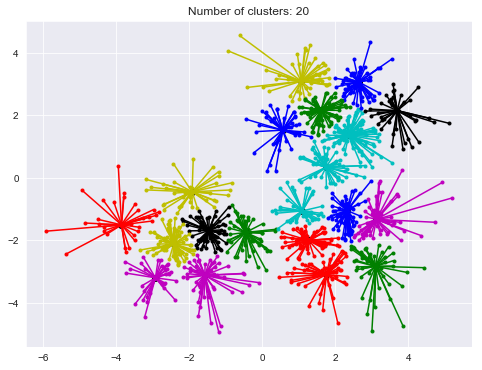

In [51]:
from itertools import cycle

plt.figure(1, figsize=(8,6))
plt.clf()

# Cycle through each cluster, graph the exemplar as a point and lines
# connecting each point to it's exemplar
colors = cycle('bgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0], 
             cluster_center[1], 
             'o', 
             markerfacecolor=col, 
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
        
plt.title(f'Number of clusters: {n_clusters_}')
plt.show()